## Step 0: Imports and Global variable init

In [8]:
! wget http://vectors.nlpl.eu/repository/20/213.zip -O fasttext.zip
! mkdir fast_text
! unzip fasttext.zip
! mv model.model fast_text
! mv model.model.vectors_ngrams.npy fast_text
! mv model.model.vectors.npy fast_text
! mv model.model.vectors_vocab.npy fast_text
! rm README
! rm meta.json

--2021-12-21 18:35:40--  http://vectors.nlpl.eu/repository/20/213.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 64:ff9b::81f0:bdb5
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|64:ff9b::81f0:bdb5|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1485270300 (1.4G) [application/zip]
Saving to: ‘fasttext.zip’

fasttext.zip        100%[===================>]   1.38G  68.3MB/s    in 20s     

2021-12-21 18:36:00 (69.7 MB/s) - ‘fasttext.zip’ saved [1485270300/1485270300]

Archive:  fasttext.zip
checkdir:  cannot create extraction directory: /fasttext
           Permission denied


In [9]:
from torch import cuda
DEVICE = 'cuda' if cuda.is_available() else 'cpu'
DESTINATION_FOLDER = 'models'
DATASETS_FOLDER = 'data'
TRAIN_TEST_RATIO = 0.1
TRAIN_VALID_RATIO = 0.8

In [10]:
import torch.optim as optim
import torch.nn as nn
import torch

import prepare_dataset 
import init_dataset_dataloader
import model 
import train_model
import evaluation

## Step 1: Train_val_test_split data

In [11]:
#download dataset and filter language if needed
df = prepare_dataset.load_data('text_dataset.csv', filter_language=True)

# choose toloka column
df = prepare_dataset.choose_toloka_answer_column(df, 'aggr_answer')

# train_test_split dataset
prepare_dataset.train_test_split_df(df, 'data/', TRAIN_TEST_RATIO, TRAIN_VALID_RATIO)

## Step 2: Load Pytorch Dataset and dataloader

In [12]:
train, valid, test, vocab = init_dataset_dataloader.create_dataset('data')
train_iter, valid_iter, test_iter = init_dataset_dataloader.create_iterators(train, valid, test, DEVICE)

## Step 3: Create model

In [13]:
fast_text_model = model.create_embed_model('fast_text/model.model')
weight_matrix = model.create_embed_matrix(vocab, fast_text_model)
model_cand = model.LSTM(weight_matrix).to(DEVICE)
optimizer = optim.Adam(model_cand.parameters(), lr=0.001)
loss = nn.BCELoss()

## Step 5: Training

In [14]:
train_model.train(model=model_cand, 
            optimizer=optimizer, 
            device=DEVICE, 
            file_path=DESTINATION_FOLDER,  
            train_loader=train_iter,
            valid_loader=valid_iter, 
            num_epochs=2,
            criterion=loss
             )

Epoch [1/2], Step [20/80], Train Loss: 0.5681, Valid Loss: 0.4716
Model saved to ==> models/model.pt
Model saved to ==> models/metrics.pt
Epoch [1/2], Step [40/80], Train Loss: 0.4744, Valid Loss: 0.4411
Model saved to ==> models/model.pt
Model saved to ==> models/metrics.pt
Epoch [2/2], Step [60/80], Train Loss: 0.4186, Valid Loss: 0.4137
Model saved to ==> models/model.pt
Model saved to ==> models/metrics.pt
Epoch [2/2], Step [80/80], Train Loss: 0.4228, Valid Loss: 0.3822
Model saved to ==> models/model.pt
Model saved to ==> models/metrics.pt
Model saved to ==> models/metrics.pt
Finished Training!


Model loaded from <== models/metrics.pt


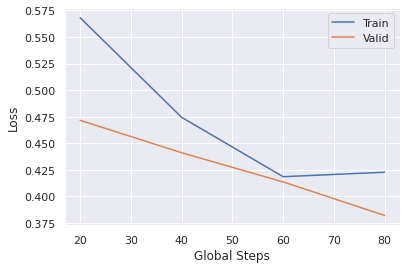

In [15]:
evaluation.plot_metrics(DESTINATION_FOLDER, DEVICE)  

## Step 6: Evaluation

Model loaded from <== models/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     1.0000    0.0110    0.0217        91
           0     0.7143    1.0000    0.8333       225

    accuracy                         0.7152       316
   macro avg     0.8571    0.5055    0.4275       316
weighted avg     0.7966    0.7152    0.5996       316



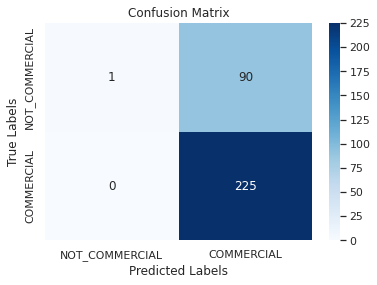

In [16]:
# Evaluation Function
best_model = model.LSTM(weight_matrix).to(DEVICE)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

evaluation.load_checkpoint(DESTINATION_FOLDER + '/model.pt', best_model, optimizer, DEVICE)
evaluation.evaluate(best_model, valid_iter, DEVICE)